# Machine Learning Modeling


In this notebook, we build an extra tree classifier to predict the likelihood of flight cancellations given flight information, weather data and some historical performances of airlines.

## Loading modules

In [1]:
import pandas as pd
import numpy as np
% pylab inline
import operator
import re
from collections import OrderedDict
import seaborn as sns
import pickle
import os.path
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Setting some plot colors and parameters

In [2]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
# Adapted from http://spartanideas.msu.edu/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
cmap_set1 = ListedColormap(['#4daf4a', '#377eb8', '#e41a1c' ])

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
sns.set_style('ticks')

## Setting data frame display

In [3]:
pd.set_option('display.max_columns', None)

## Loading the data

We have acquired and merged the data in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/DataAcquisitionMerging/data_acquisition_merging.ipynb). The merged data was also cleaned by fixing the missing values in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/DataCleaning/data_cleaning.ipynb). A lot of features from the cleaned data was removed (or some features were selected) in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/EDA/ExploratoryDataAnalysis_v1.ipynb). The resultant csv file is loaded below:

In [4]:
df = pd.read_csv("../Data/ExploredDataCleaned/FlightHistory_Weather_Jan2015-Dec2016_Top20Airports_Window60mins_ExploredCleaned.csv")

In [5]:
df.shape

(2857139, 69)

In [6]:
df.head()

,Unnamed: 0,Month,DayofMonth,DayOfWeek,Carrier,Origin,Dest,Cancelled,Distance,Nflights_10,DepDelayMedian_10,DepDelayMax_10,ArrDelayMedian_10,ArrDelayMax_10,TaxiOutMedian_10,TaxiInMedian_10,Ncan_10,Ndiv_10,Nflights_20,DepDelayMedian_20,DepDelayMax_20,ArrDelayMedian_20,ArrDelayMax_20,TaxiOutMedian_20,TaxiInMedian_20,Ncan_20,Ndiv_20,Nflights_30,DepDelayMedian_30,DepDelayMax_30,ArrDelayMedian_30,ArrDelayMax_30,TaxiOutMedian_30,TaxiInMedian_30,Ncan_30,Ndiv_30,CRSDepHr,CRSArrHr,Temperature_Origin,DewPoint_Origin,Humidity_Origin,WindSpeed_Origin,WindDirection_Origin,Visibility_Origin,Pressure_Origin,Condition_Origin,Temperature_Dest,DewPoint_Dest,Humidity_Dest,WindSpeed_Dest,WindDirection_Dest,Visibility_Dest,Pressure_Dest,Condition_Dest,Month_Dest,DayOfMonth_Dest,DayOfWeek_Dest,TempFlight_30,TempFlight_20,TempFlight_10,AllCanceled_30,AllDiverted_30,AllCanceled_20,AllDiverted_20,AllCanDiv_20,AllCanDiv_30,AllCanceled_10,AllDiverted_10,AllCanDiv_10
0,0,1,1,4,AA,PHX,DFW,1.0,868.0,10,-2.0,0.0,-2.5,17.0,13.0,4.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,2,5,37.0,30.0,76.0,3.5,320.0,10.0,30.04,Scattered Clouds,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,4,NK,PHX,DFW,0.0,868.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,37.0,30.9,79.0,4.6,300.0,10.0,30.03,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0
2,2,1,1,4,DL,DEN,ATL,0.0,1199.0,10,3.5,48.0,-7.5,52.0,15.0,6.5,0.0,0.0,12,3.5,48.0,-7.5,52.0,14.5,6.5,0.0,0.0,12,3.5,48.0,-7.5,52.0,14.5,6.5,0.0,0.0,0,5,7.0,-8.0,51.0,15.0,170.0,10.0,30.22,Clear,33.1,26.1,75.0,3.5,310.0,10.0,30.32,Partly Cloudy,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0
3,3,1,1,4,NK,LAS,MSP,0.0,1299.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5,34.0,17.1,50.0,9.2,190.0,10.0,29.99,Mostly Cloudy,16.0,10.0,77.0,8.1,240.0,10.0,29.90,Overcast,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0
4,4,1,1,4,NK,LAS,DFW,0.0,1055.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,32.0,17.1,54.0,10.4,190.0,10.0,30.00,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0


In [7]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [8]:
df.head()

,Month,DayofMonth,DayOfWeek,Carrier,Origin,Dest,Cancelled,Distance,Nflights_10,DepDelayMedian_10,DepDelayMax_10,ArrDelayMedian_10,ArrDelayMax_10,TaxiOutMedian_10,TaxiInMedian_10,Ncan_10,Ndiv_10,Nflights_20,DepDelayMedian_20,DepDelayMax_20,ArrDelayMedian_20,ArrDelayMax_20,TaxiOutMedian_20,TaxiInMedian_20,Ncan_20,Ndiv_20,Nflights_30,DepDelayMedian_30,DepDelayMax_30,ArrDelayMedian_30,ArrDelayMax_30,TaxiOutMedian_30,TaxiInMedian_30,Ncan_30,Ndiv_30,CRSDepHr,CRSArrHr,Temperature_Origin,DewPoint_Origin,Humidity_Origin,WindSpeed_Origin,WindDirection_Origin,Visibility_Origin,Pressure_Origin,Condition_Origin,Temperature_Dest,DewPoint_Dest,Humidity_Dest,WindSpeed_Dest,WindDirection_Dest,Visibility_Dest,Pressure_Dest,Condition_Dest,Month_Dest,DayOfMonth_Dest,DayOfWeek_Dest,TempFlight_30,TempFlight_20,TempFlight_10,AllCanceled_30,AllDiverted_30,AllCanceled_20,AllDiverted_20,AllCanDiv_20,AllCanDiv_30,AllCanceled_10,AllDiverted_10,AllCanDiv_10
0,1,1,4,AA,PHX,DFW,1.0,868.0,10,-2.0,0.0,-2.5,17.0,13.0,4.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,2,5,37.0,30.0,76.0,3.5,320.0,10.0,30.04,Scattered Clouds,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,4,NK,PHX,DFW,0.0,868.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,37.0,30.9,79.0,4.6,300.0,10.0,30.03,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0
2,1,1,4,DL,DEN,ATL,0.0,1199.0,10,3.5,48.0,-7.5,52.0,15.0,6.5,0.0,0.0,12,3.5,48.0,-7.5,52.0,14.5,6.5,0.0,0.0,12,3.5,48.0,-7.5,52.0,14.5,6.5,0.0,0.0,0,5,7.0,-8.0,51.0,15.0,170.0,10.0,30.22,Clear,33.1,26.1,75.0,3.5,310.0,10.0,30.32,Partly Cloudy,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,4,NK,LAS,MSP,0.0,1299.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5,34.0,17.1,50.0,9.2,190.0,10.0,29.99,Mostly Cloudy,16.0,10.0,77.0,8.1,240.0,10.0,29.90,Overcast,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0
4,1,1,4,NK,LAS,DFW,0.0,1055.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,32.0,17.1,54.0,10.4,190.0,10.0,30.00,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0


In [9]:
df.shape

(2857139, 68)

There are some variables with numerical values and some variables with categories. For numerical variables, we do not have to worry about labelling. However, we will need to perform label encoding for the categorical variables. There are also some variables that are already in binary form, so that also does not need any labeling. Let's first identify all the numerical, categorical and binary variables.

In [10]:
numvar = ["Distance", "Nflights_10", "DepDelayMedian_10", "DepDelayMax_10", "ArrDelayMedian_10",
          "ArrDelayMax_10", "TaxiOutMedian_10", "TaxiInMedian_10", "Ncan_10", "Ndiv_10", "Nflights_20",
          "DepDelayMedian_20", "DepDelayMax_20", "ArrDelayMedian_20", "ArrDelayMax_20", "TaxiOutMedian_20",
          "TaxiInMedian_20", "Ncan_20", "Ndiv_20", "Nflights_30", "DepDelayMedian_30", "DepDelayMax_30", 
          "ArrDelayMedian_30", "ArrDelayMax_30", "TaxiOutMedian_30", "TaxiInMedian_30", "Ncan_30", 
          "Ndiv_30", "Temperature_Origin", "DewPoint_Origin", "Humidity_Origin", "WindSpeed_Origin", 
          "WindDirection_Origin", "Visibility_Origin", "Pressure_Origin", "Temperature_Dest", "DewPoint_Dest",
          "Humidity_Dest", "WindSpeed_Dest", "WindDirection_Dest", "Visibility_Dest", "Pressure_Dest"]
catvar = ["Month", "DayofMonth", "DayOfWeek", "Carrier", "Origin", "Dest", "CRSDepHr", "CRSArrHr", 
          "Condition_Origin", "Condition_Dest", "Month_Dest", "DayOfMonth_Dest", "DayOfWeek_Dest"]
binvar = ["TempFlight_30", "TempFlight_20", "TempFlight_10", "AllCanceled_30", "AllDiverted_30", 
          "AllCanceled_20", "AllDiverted_20", "AllCanDiv_20", "AllCanDiv_30", "AllCanceled_10", 
          "AllDiverted_10", "AllCanDiv_10"]

## Converting string values to numerical values in all categorical columns

In [11]:
#from sklearn.preprocessing import LabelEncoder
#lbl_enc = LabelEncoder()
#tmp = df[catvar].apply(lbl_enc.fit_transform) 
#df.drop(catvar, axis=1, inplace=True)
#df = pd.concat([df, tmp], axis=1)

In [12]:
#One-hot-encoding
for cvar in catvar:
    df = pd.concat([df, pd.get_dummies(df[cvar], prefix=cvar, dummy_na=False)], axis=1)
    df.drop([cvar], axis=1, inplace=True)

In [13]:
df.shape

(2857139, 331)

In [14]:
colnames = list(df.columns[1:])

## Creating feature matrix and target vector

In [15]:
X = df.drop(["Cancelled"], axis=1).values
y = df.Cancelled.astype(int).values

In [16]:
X.shape

(2857139, 330)

## Splitting the data into train (75%) and test (25%) sets

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=20)
for train_index, test_index in sss1.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [18]:
X_train.shape

(2142854, 330)

In [19]:
X_test.shape

(714285, 330)

Just to make sure that stratified shuffle split led to train and test with same fraction of positive class, lets calculate the fractions.

In [20]:
sum(df.iloc[train_index].Cancelled == 1)/len(train_index)

0.011486550180273598

In [21]:
sum(df.iloc[test_index].Cancelled == 1)/len(test_index)

0.011487011487011487

They are indeed quite similar.

In [23]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
ETfull = ExtraTreesClassifier(random_state=40, n_estimators = 100, min_samples_leaf=4, class_weight="balanced", n_jobs = -1)
ETfull.fit(X_train, y_train)

CPU times: user 1h 43min 12s, sys: 30 s, total: 1h 43min 42s
Wall time: 14min 30s


In [24]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold
average_precision_score(y_test, ETfull.predict_proba(X_test)[:,1])

0.40371576850900165

In [ ]:
sfm = SelectFromModel(ETfull, threshold=0.0015, prefit=True)

X_train_select = sfm.transform(df.iloc[train_index].drop(["Cancelled"], axis=1))
X_train_select = pd.DataFrame(X_train_select)
Xs_train = X_train_select.values
ys_train = df.iloc[train_index].Cancelled.astype(int).values

X_test_select = sfm.transform(df.iloc[test_index].drop(["Cancelled"], axis=1))
X_test_select = pd.DataFrame(X_test_select)
Xs_test = X_test_select.values
ys_test = df.iloc[test_index].Cancelled.astype(int).values

ETpartial = ExtraTreesClassifier(random_state=30, n_estimators = 100, min_samples_leaf=4, class_weight="balanced", n_jobs = -1)
ETpartial.fit(Xs_train, ys_train)

In [26]:
print(average_precision_score(ys_test, ETpartial.predict_proba(Xs_test)[:,1]))

0.40648453157


In [39]:
selected_features = df.drop(["Cancelled"], axis=1).columns[sfm.get_support()]

In [41]:
df[selected_features].shape

(2857139, 238)

There are some features that look like they should not be present in the model. Lets try to remove them and see what happens to PR AUC.

In [42]:
# list of features that can be removed
remove_features_list = ["Month_Dest_2", "Month_Dest_1", "Month_Dest_9", "DayOfWeek_Dest_5", "DayOfWeek_Dest_2",
                        "DayOfWeek_Dest_4", "DayOfWeek_Dest_1", "DayOfWeek_Dest_3", "DayOfWeek_Dest_7",
                        "DayOfWeek_Dest_6", "Month_Dest_11", "DayOfMonth_Dest_24", "DayOfMonth_Dest_27",
                        "Month_Dest_8", "Month_Dest_10", "DayOfMonth_Dest_23", "Month_Dest_3", "Month_Dest_12",
                        "DayOfMonth_Dest_9", "Month_Dest_4", "Month_Dest_6", "DayOfMonth_Dest_8", "Month_Dest_7",
                        "DayOfMonth_Dest_28", "Month_Dest_5", "DayOfMonth_Dest_7", "DayOfMonth_Dest_22", 
                        "DayOfMonth_Dest_10", "DayOfMonth_Dest_21", "DayOfMonth_Dest_15", "DayOfMonth_Dest_25",
                        "DayOfMonth_Dest_2", "DayOfMonth_Dest_17", "DayOfMonth_Dest_18", "DayOfMonth_Dest_26",
                        "DayOfMonth_Dest_5", "DayOfMonth_Dest_20", "DayOfMonth_Dest_4", "DayOfMonth_Dest_11",
                        "DayOfMonth_Dest_16", "DayOfMonth_Dest_6", "DayOfMonth_Dest_12", "DayOfMonth_Dest_19",
                        "DayOfMonth_Dest_1", "DayOfMonth_Dest_3", "DayOfMonth_Dest_13", "DayOfMonth_Dest_29",
                        "DayOfMonth_Dest_30"]

In [47]:
updated_features_list = [f for f in list(selected_features) if f not in remove_features_list]

In [52]:
Xs_train1 = df.iloc[train_index][updated_features_list].values
ys_train1 = df.iloc[train_index].Cancelled.astype(int).values

Xs_test1 = df.iloc[test_index][updated_features_list].values
ys_test1 = df.iloc[test_index].Cancelled.astype(int).values

ETpartial1 = ExtraTreesClassifier(random_state=30, n_estimators = 100, min_samples_leaf=4, class_weight="balanced", n_jobs = -1)
ETpartial1.fit(Xs_train1, ys_train1)
print(average_precision_score(ys_test1, ETpartial1.predict_proba(Xs_test1)[:,1]))

0.38888250551


#####################
Test data
#####################
F1:  0.434005404282
Cohen Kappa:  0.428338208592
Brier:  0.0114366114366
LogLoss:  0.0671313152597
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    706080
          1       0.50      0.38      0.43      8205

avg / total       0.99      0.99      0.99    714285



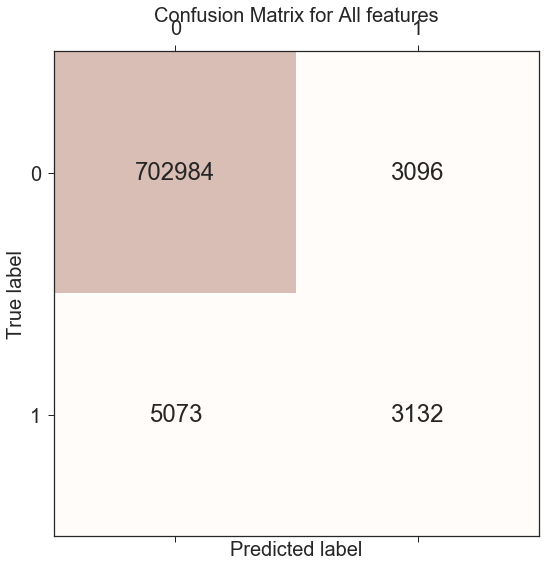

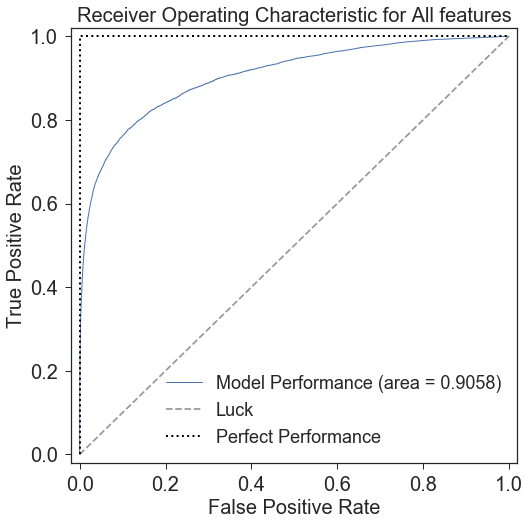

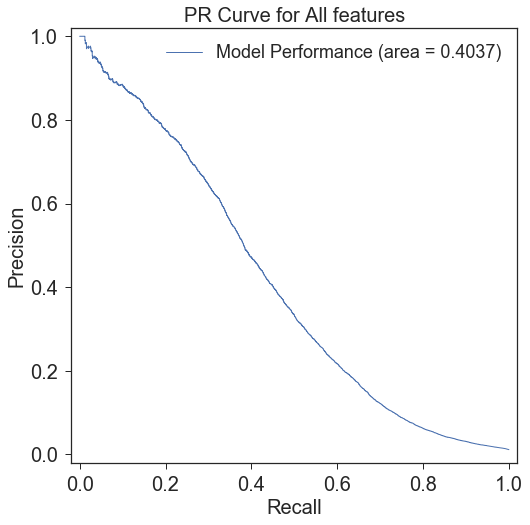

In [61]:
result(ETfull, X_train, y_train, X_test, y_test, train_result=False, clf_name="All features")

#####################
Test data
#####################
F1:  0.437074949169
Cohen Kappa:  0.431527866759
Brier:  0.0112406112406
LogLoss:  0.0654934449389
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    706080
          1       0.51      0.38      0.44      8205

avg / total       0.99      0.99      0.99    714285



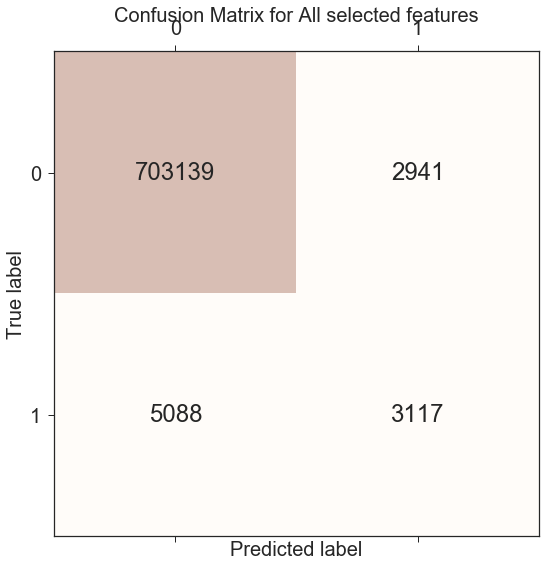

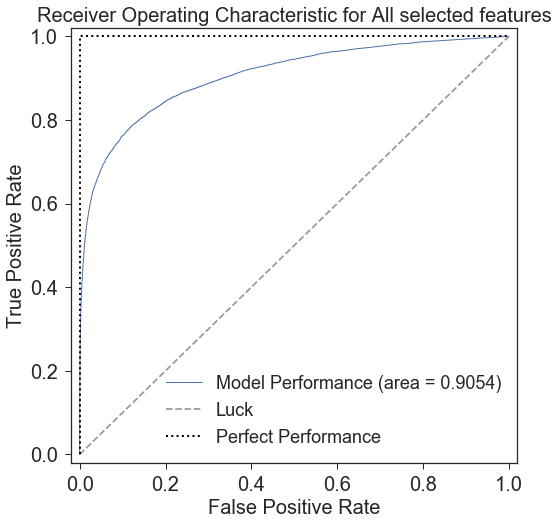

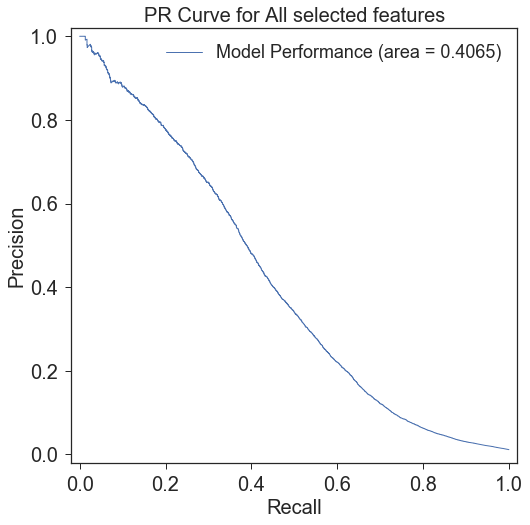

In [59]:
result(ETpartial, Xs_train, ys_train, Xs_test, ys_test, train_result=False, clf_name="All selected features")

#####################
Test data
#####################
F1:  0.425962264151
Cohen Kappa:  0.420896575701
Brier:  0.0106484106484
LogLoss:  0.0658722510722
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    706080
          1       0.56      0.34      0.43      8205

avg / total       0.99      0.99      0.99    714285



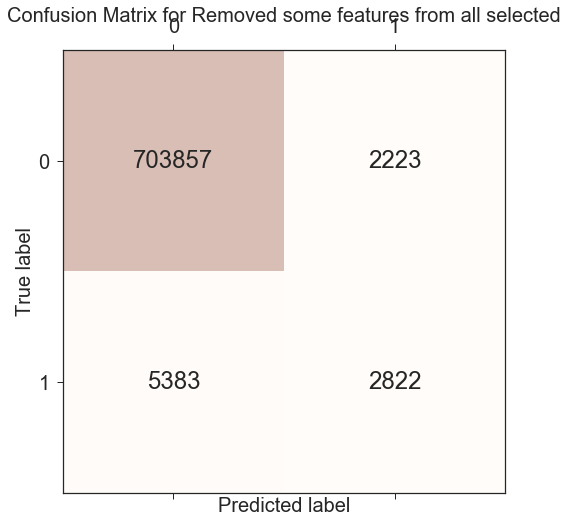

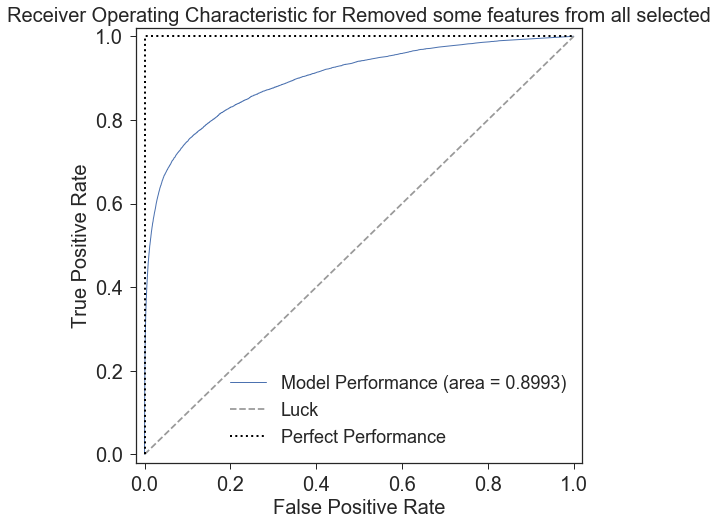

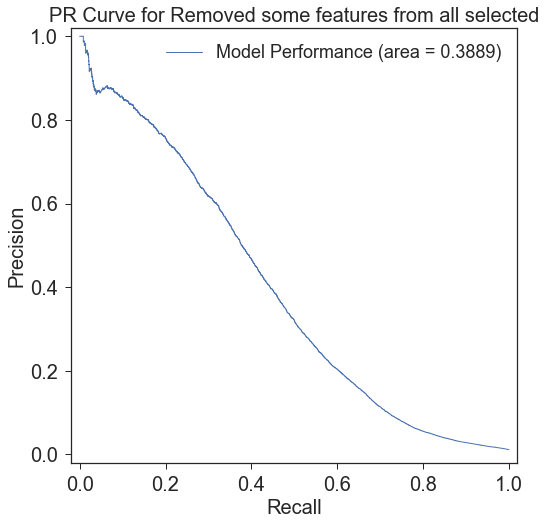

In [60]:
result(ETpartial1, Xs_train1, ys_train1, Xs_test1, ys_test1, train_result=False, clf_name="Removed some features from all selected")

Although the difference is not much, there is still some difference! We dont want to loose any information, so lets keep all 238 selected features. Lets now save the final model.

In [62]:
import dill
dill.dump(ETpartial, open('ExtraTree_selected_features.pkl', 'wb'))

## Function to calculate various evaluation metrics and plot ROC and PR curves

In [57]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, cohen_kappa_score
def result(model, X_train, y_train, X_test, y_test, train_result, clf_name):
    """ This function calculates different metrics to show the model's performance on both training and test data.
    This functoin also shows the confusion matrix, and plots the ROC and PR curves.
    
    Parameters
    ----------
    model (dtype: sklearn.model_selection._search.GridSearchCV) : The classifier model
    train_result (dtype: boolean): If YES, calculate results for train data
    clf_name (dtype: str): Name of the classifier
    """
    if train_result:
        y_pred_train = model.predict(X_train) # class prediction
        y_pred_train_prob = model.predict_proba(X_train) # probability of each class prediction
        print("#####################")
        print("Train data")
        print("#####################")
        print("F1: ", metrics.f1_score(y_train, y_pred_train))
        print("Cohen Kappa: ", metrics.cohen_kappa_score(y_train, y_pred_train))
        print("Brier: ", metrics.brier_score_loss(y_train, y_pred_train))
        print("LogLoss: ", metrics.log_loss(y_train, y_pred_train_prob))
        print(metrics.classification_report(y_train, y_pred_train))
        print(metrics.confusion_matrix(y_train, y_pred_train))
    else:
        pass
    
    y_pred_test = model.predict(X_test)
    y_pred_test_prob = model.predict_proba(X_test)
    print("#####################")
    print("Test data")
    print("#####################")
    print("F1: ", metrics.f1_score(y_test, y_pred_test))
    print("Cohen Kappa: ", metrics.cohen_kappa_score(y_test, y_pred_test))
    print("Brier: ", metrics.brier_score_loss(y_test, y_pred_test))
    print("LogLoss: ", metrics.log_loss(y_test, y_pred_test_prob))
    print(metrics.classification_report(y_test, y_pred_test))
    conf_matrix = metrics.confusion_matrix(y_test, y_pred_test)
    
    # Displaying the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', fontsize=24)

    plt.title('Confusion Matrix for %s' % clf_name, size=20)
    plt.xlabel('Predicted label', size=20)
    plt.ylabel('True label', size=20)
    ax.tick_params('x', labelsize = 20)
    ax.tick_params('y', labelsize = 20)
    plt.tight_layout()
    
    # ROC curve
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='Model Performance (area = %0.4f)' % (roc_auc))
    plt.plot([0, 1], 
             [0, 1], 
             '--', 
             color=(0.6, 0.6, 0.6), 
             label='Luck')
    
    plt.plot([0, 0, 1], 
             [0, 1, 1], 
             lw=2,
             linestyle=':',
             color='black',
             label='Perfect Performance')
        
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', size=20)
    plt.ylabel('True Positive Rate', size=20)
    plt.title('Receiver Operating Characteristic for %s' % clf_name, size=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.legend(loc="lower right", fontsize=18)
    
    # PR curve
    fig2, ax2 = plt.subplots(figsize=(8, 8))
    prec, recall, thresholds = precision_recall_curve(y_test, y_pred_test_prob[:, 1])
    #pr_auc = auc(prec, recall)
    plt.plot(recall, prec, lw=1, label='Model Performance (area = %0.4f)' % 
             (metrics.average_precision_score(y_test, y_pred_test_prob[:, 1])))    
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('Recall', size=20)
    plt.ylabel('Precision', size=20)
    plt.title('PR Curve for %s' % clf_name, size=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.legend(loc="top right", fontsize=18)